# COGS 108 - Final Project Proposal

# Names

- Myra Haider
- Molly Rowland
- Brian Cheng
- Zack Neese

# Overview

In our Project we will be looking at a data set of Airbnb reviews and bookings and trying to determine the busiest time of year for tourism to New York City, as well as if that trend varies when broken down into its many districts. Rather than comparing the popularity of different destinations we hope to find much more interesting results when looking at the same destination through different parts of the year. After cleaning and processing to remove any data points that prove unethical or breach privacy, we then go into more in depth analysis and visualization with a primary focus on comparing Manhattan and Brooklyn as those are the two boroughs that have the most listings and therefore the most interesting areas to draw conclusions for.

# Question
What are New York City’s most popular times of the year for Airbnb tourism? Does it vary by location within the City? (If it does vary, does price factor into this variance?)

We hypothesize that in general summer will be the most popular time of year for tourism to NYC, however we expect to see a bump in tourism in Manhattan around New Years Eve.



# Background

We have found most data science efforts related to Airbnb data in the past were about the most trendy places to visit. (Example: https://www.cnbc.com/2019/10/13/airbnb-top-trending-travel-destinations-for-2020.html) It is likely this is because it is a simply analysis (just look if bookings are going up or down over time) and because despite that the data is impactful, knowing that a place is rising in tourism can be a factor that causes humans to visit there more as a kind of fear of missing out or an attempt to stay trendy and “ahead of the curve”.
Rather than Dissecting where to plan your next family vacation we seek to use this data to help make informed decisions about when in the year to make that trip (specifically to new york). Also delving into its local neighborhoods and seeing if staying a bit further from your intended location could save you some money.


# Data Description
Our data set features over 50 thousand Airbnb listings within the city of New York, each of these listings contains a unique ID identifier, a listing name, a host ID identifier, the first name of the host, the borough within New York City the listing is in, the neighborhood within that borough, the latitude and longitude of the listing, the room type, the price per night in USD, the minimum number of nights a users must book, the number of reviews the listing has had, the date of the most recent review, the average reviews per month, the number of listings this host of this listing has, how many days out of the year the listing is available, and lastly the month of the booking. However not all of this data is necessary for our analysis, instead we will be looking specifically at the boroughs, the Latitude and Longitude, the room type, the price, and the month. Using this data we will be able to break down data into their specific boroughs and plot them geographically using the Latitude and longitude, then use price, room type, and month to do further analysis. 


# Privacy and Ethics
The data is publically available online for the purpose of exploratory analysis, with every Airbnb listing in NYC being included in the dataset. Upon initial inspection of the data, the only immediate concern we had with data privacy was the information regarding Airbnb hosts. In order to ensure our data follows Safe Harbour guidelines, we dropped all personally identifiable information such as the Host name and the Host ID. The guidelines require that identifiers such as name, ID, phone numbers, and address are removed. The only potential privacy concern to note are locations of the listings themselves, however there is no connection between each listing and an individual in the dataset once it is cleaned. 

In terms of potential biases, we are primarily focusing on Manhattan and Brooklyn as those burrows have the most listings in our dataset. We may not be able to generalize our conclusions for all of New York City or any other travel destination. It's also important to note that while we are looking to determine the most popular time of year for tourism, we are only looking at data from Airbnb. There are many other options for visitors to stay in NYC, including hotels, hostels, subleasing, or staying with friends/family. Studying the popularity of these options as well may give us better insight as to when travel times are busiest. However, because many hotels and homeowners also list their rooms on Airbnb, the data should be comprehensive enough to perform our analysis.

# Analysis
The datasets being used for analysis are from http://insideairbnb.com/get-the-data.html, a website that compiles all publically available listing information from the Airbnb website into tabular data. We chose to use 12 datasets containing all of the listings for New York City, one for each month of 2019. We then combined them into a single dataframe so that we could study how listing prices fluctuate throughout the entire year. The cleaning required was fairly minimal, as the original datasets were already standardized for easy use. 

In [19]:
import pandas as pd
import geopandas as gp
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [20]:
calendar = pd.read_csv("/Users/mollyrowland/Downloads/GitHub/group049_wi20/datasets/2019listings/listings1.csv")
neighborhoods = pd.read_csv("/Users/mollyrowland/Downloads/GitHub/group049_wi20/datasets/neighbourhoods.csv")

In [21]:
#Read in listings from each month of 2019, combine them into one dataframe

dataframes = []

for i in range(1,13):
    path = "datasets/2019listings/listings" + str(i) + ".csv"
    df = pd.read_csv(path)
    df["month"]= i
    dataframes.append(df)
    
listings = pd.concat(dataframes)

In [22]:
#Convert last_review to datetime 
listings['last_review'] = pd.to_datetime(listings['last_review'])

We made two seperate dataframes for analysis, one that looks at the most recent listing avaliable in order to spatially look at our data, and another of all the listings so that we could check booking patterns, price changes, and other values. 


In [23]:
#data cleaning to ensure Safe Harbor standards
listings=listings[['id','name','neighbourhood_group','neighbourhood','latitude','longitude','room_type','price','minimum_nights','number_of_reviews','last_review','reviews_per_month','calculated_host_listings_count','availability_365','month']]
price_0=listings[listings['price']==0].index
listings.drop(index=price_0, inplace=True)
#each indiviudal listing 
individual_listings = listings.sort_values('last_review').drop_duplicates('id',keep='last')
brooklyn=listings[listings['neighbourhood_group']=="Brooklyn"]
manhattan=listings[listings['neighbourhood_group']=="Manhattan"]
listings.head()

,id,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,month
0,2515,Stay at Chez Chic budget room #1,Manhattan,Harlem,40.799205,-73.953676,Private room,59,2,175,2018-12-29,1.40,3,310,1
1,2539,Clean & quiet apt home by the park,Brooklyn,Kensington,40.647486,-73.972370,Private room,149,1,9,2018-10-19,0.24,8,365,1
2,2595,Skylit Midtown Castle,Manhattan,Midtown,40.753621,-73.983774,Entire home/apt,225,1,43,2019-01-02,0.39,2,365,1
3,3330,++ Brooklyn Penthouse Guestroom ++,Brooklyn,Williamsburg,40.708558,-73.942362,Private room,70,5,39,2018-12-07,0.36,3,282,1
4,3647,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.809018,-73.941902,Private room,150,3,0,NaT,NaN,1,365,1


When beginning our analysis, we started by taking our new dataframes, trying to extract data from them about when the bookings were occuring, the borough, the neighbourhood, the room type and price. These are all interesting values to look into when looking for New York’s busiest time for Airbnb bookings. New York is a large city so by looking in each borough and neighbourhood we can locate the more popular tourist destinations. Further it is interesting to see what sort of rooms are going. Airbnb offers a variety of flexible options for all travelers such as a shared room, a private room, entire apartments or house, and even some hotels have been listing their rooms on Airbnb to increase their visibility. As these are all different types of rooms that accomodate different numbers of people and different privacy levels, it’s important to look at their aggregate values separately to make the data more meaningful. Therefore we will be framing our analysis by looking for different prices, across different room types and areas throughout the year. 


As we can see from the graph below, there are many bookings throughout New York City year round. However, the most popular months do seem to be the winter and spring, while bookings actually lower during the summer and fall.

Text(0.5, 1.0, 'Number of bookings in New York City per month')

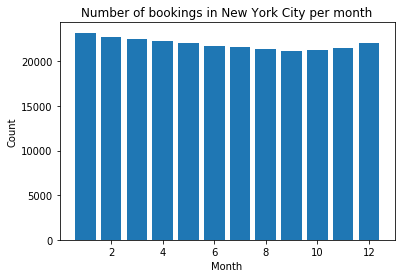

In [24]:
listings_months = listings.groupby(['neighbourhood_group','month'])['id'].count().reset_index()
listings_months.rename(columns={'id':'bookings_per_month'}, inplace=True)
plt.bar(listings_months['month'].tolist(), listings_months['bookings_per_month'].tolist())
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Number of bookings in New York City per month')


The graph below looks at the count of listings per month. The graph illustrates that there is a huge jump in listings, specifically in Brooklyn during December. This goes along with the above graph that December is a busy month in New York City, especially in Brooklyn.

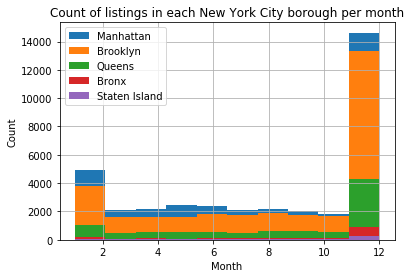

In [31]:
boroughs = individual_listings.groupby('neighbourhood_group').count().sort_values('name', ascending = False).index.tolist()
for borough in boroughs:
    individual_listings[individual_listings['neighbourhood_group'] == borough]['month'].hist()
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Count of listings in each New York City borough per month')
plt.legend(borrows)

Here we are looking at listings per month for Brooklyn and we can see that December is the busiest month with 20,656 listings total.

In [32]:
brooklyn_months=brooklyn.groupby(['month'])['id'].count().reset_index()
brooklyn_months.rename(columns={'id':'listings_per_month'}, inplace=True)
brooklyn_months

,month,listings_per_month
0,1,20553
1,2,20427
2,3,20239
3,4,20104
4,5,19906
5,6,19940
6,7,20031
7,8,20045
8,9,19786
9,10,19826


In [33]:
brooklyn_months[brooklyn_months['listings_per_month']==brooklyn_months["listings_per_month"].max()]

,month,listings_per_month
11,12,20656


In Manhattan we can see that the busiest month is January, with 23,202. This is considerably more listings than in Brooklyn. We believe this to be because of proximity to tourist destinations. 



In [34]:
manhattan_months=manhattan.groupby(['month'])['id'].count().reset_index()
manhattan_months.rename(columns={'id':'listings_per_month'}, inplace=True)
manhattan_months

,month,listings_per_month
0,1,23202
1,2,22765
2,3,22487
3,4,22288
4,5,22016
5,6,21727
6,7,21590
7,8,21390
8,9,21121
9,10,21210


In [35]:
manhattan_months[manhattan_months['listings_per_month']==manhattan_months["listings_per_month"].max()]


,month,listings_per_month
0,1,23202


This graph below looks at the count of Airbnb prices per borough. We can see that Manhattan seems to have a high count of expensive properties, but Brooklyn has a lot of less expensive options.


Text(0.5, 1.0, 'Count of Airbnb Prices in each New York City borough')

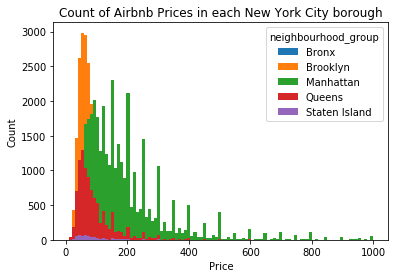

In [36]:
#looking at prices per borrow
individual_listings[individual_listings['price']<1000][['neighbourhood_group','price']].reset_index().pivot(columns='neighbourhood_group', values='price').plot.hist(bins=100)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Count of Airbnb Prices in each New York City borough')                                                                         

Here we can see that the average price in Manhattan is at least doubled for all the boroughs besides Brooklyn. These prices, along with the count of properties available, show that Manhattan and Brooklyn are the two main destinations for Airbnb bookings. 


In [42]:
#average price per borrow
individual_listings.groupby('neighbourhood_group')['price'].mean().astype(int)

neighbourhood_group
Bronx             87
Brooklyn         126
Manhattan        216
Queens           101
Staten Island    110
Name: price, dtype: int64

Here we can look for prices of listing per month for each borough. We can see the prices fluctuate throughout, showing peaks in the November and January for most boroughs. There are also increased during the summer for places such as the Bronx and especially Staten Island, with a over \$200 increase from August to September.

In [43]:
#price average per month
individual_listings.groupby(['neighbourhood_group','month'])['price'].mean().astype(int)

neighbourhood_group  month
Bronx                1         91
                     2         87
                     3         69
                     4         92
                     5         72
                     6         83
                     7        104
                     8        102
                     9         80
                     10        82
                     11        95
                     12        86
Brooklyn             1        112
                     2        125
                     3        116
                     4        119
                     5        125
                     6        140
                     7        131
                     8        133
                     9        129
                     10       128
                     11       129
                     12       125
Manhattan            1        183
                     2        181
                     3        204
                     4        203
                     

Most of the listing are in notable New York neighbors such as Harlem and Hell's Kitchen. 

In [105]:
individual_listings.groupby(['neighbourhood_group', 'neighbourhood'])['id'].count().sort_values(ascending=False)[:10]

neighbourhood_group  neighbourhood     
Brooklyn             Williamsburg          6092
                     Bedford-Stuyvesant    5777
Manhattan            Harlem                4137
Brooklyn             Bushwick              3868
Manhattan            Hell's Kitchen        3838
                     Upper West Side       3126
                     Upper East Side       3008
                     East Village          2950
                     Midtown               2768
Brooklyn             Crown Heights         2357
Name: id, dtype: int64

In Brooklyn, we can see that the average in Sea Gate is almsot \$500, followed by Manhattan Beach with almost 100 dollar decrease. 

In [54]:
#Average price per neighborhoods in Brooklyn
brooklyn.groupby(["neighbourhood"])['price'].mean().sort_values(ascending=False)[:10]

neighbourhood
Sea Gate            493.172414
Manhattan Beach     395.576923
DUMBO               221.123288
Brooklyn Heights    208.988518
Cobble Hill         200.283376
Boerum Hill         184.656532
Vinegar Hill        183.655779
Clinton Hill        182.987284
Carroll Gardens     175.872138
Park Slope          169.717050
Name: price, dtype: float64

In Manhattan we can see that similarly to Brooklyn, there is a \$100 difference between Tribeca and Battery Park City, with a similar max values. 

In [55]:
#Average price per neighborhoods in Manhattan
manhattan.groupby(["neighbourhood"])['price'].mean().sort_values(ascending=False)[:10]

neighbourhood
Tribeca              460.952609
Battery Park City    346.050175
Theater District     329.577840
Flatiron District    325.877960
NoHo                 301.376652
SoHo                 292.359946
Midtown              286.599580
West Village         266.392823
Greenwich Village    257.629012
Chelsea              250.124470
Name: price, dtype: float64

Sea Gate, Brooklyns most expensive neighborhood offers option for only an entire apartment or a private room.

In [74]:
#most expensive neighbourhood
neighbourhood_avg=brooklyn.groupby(["neighbourhood", 'room_type'])['price'].mean().reset_index()
neighbourhood_avg[neighbourhood_avg['neighbourhood']=='Sea Gate']


,neighbourhood,room_type,price
123,Sea Gate,Entire home/apt,649.047619
124,Sea Gate,Private room,84.000000


Tribeca, Manhattan's most expensive neighborhood has a variety of different options avaliable including shared room and hotel. 

In [75]:
neighbourhood_avg_1=manhattan.groupby(["neighbourhood", 'room_type'])['price'].mean().reset_index()
neighbourhood_avg_1[neighbourhood_avg_1['neighbourhood']=='Tribeca']


,neighbourhood,room_type,price
89,Tribeca,Entire home/apt,538.387630
90,Tribeca,Hotel room,479.666667
91,Tribeca,Private room,181.574944
92,Tribeca,Shared room,190.000000


Now that we have explored the neighborhoods of Brooklyn and Manhattan more extensively, lets check to see how prices fluctuate across the months. 

From the two tables we can see that generally November and December are the most expensive times of year in Brooklyn. However, we can also see that the summer prices also fluctuate, with lows in January and Febuary, as well as September.

In [76]:
brooklyn.groupby('month')['price'].mean()

month
1     121.234662
2     121.634259
3     120.882899
4     121.812923
5     122.624083
6     124.304965
7     124.503869
8     124.143028
9     122.986051
10    123.605518
11    124.043264
12    124.519849
Name: price, dtype: float64

In [77]:
manhattan.groupby('month')['price'].mean()

month
1     192.207396
2     192.903141
3     194.784942
4     196.713792
5     199.436092
6     197.556082
7     196.963038
8     195.118046
9     199.683585
10    198.772466
11    208.293374
12    211.023347
Name: price, dtype: float64

Manhattan has a signficantly higher count of listings above $1000 with 2127, while Brooklyn only has 613

In [37]:
#number of listings over $1000 
manhattan[manhattan['price']>1000].groupby('neighbourhood')['id'].count().sort_values(ascending=False)[:5]

neighbourhood
Midtown            280
Upper West Side    244
West Village       167
Chelsea            165
Tribeca            130
Name: id, dtype: int64

In [83]:
#number of listings over $1000 
brooklyn[brooklyn['price']>1000].groupby('neighbourhood')['id'].count().sort_values(ascending=False)[:5]

neighbourhood
Bedford-Stuyvesant    121
Williamsburg          119
Clinton Hill           42
Crown Heights          40
Brooklyn Heights       27
Name: id, dtype: int64

After looking specifically at Brooklyn and Manhattan, we are able to see that the busiest time in New York is around November-January. This is likely due to holidays such as Thanksgiving, Christmas, and New Years that increase travel to these areas. 

However, we were also able to see that the summer also had an increase in prices which can also be associated with summer tourism. 

We are also interested in seeing how the data is distributed geographically across New York City, and specifically Manhattan and Brooklyn. In order to explore this some more, we are going to use the spaital data to plot it and look at the aggreates 

In addition to the data already provided, there will be a subset of data points from the Berkeley Library of Geodata to look at a few landmark locations, as well as geodata from opendata for the city of New York inorder to create better maps. 
https://opendata.cityofnewyork.us/
https://geodata.lib.berkeley.edu/

First we start by creating the geometry column from our lat and long so that the data is plotable. We also declare the crs so that all the data uses the same spatial system. 

We did this for both Manhattan data and Brooklyn data. We chose to only look at these two however because of the memory and processing constraints of creating spatial data. 

In [40]:
#create spatial dataframe
geometry = [Point(xy) for xy in zip(manhattan.drop_duplicates(subset=['id'])['longitude'], manhattan.drop_duplicates(subset=['id'])['latitude'])]
# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
manhattan_gdf = gp.GeoDataFrame(manhattan.drop_duplicates(subset=['id']), crs=crs, geometry=geometry)
manhattan_gdf.drop(columns=["latitude", "longitude"], inplace=True)

In [41]:
geometry_1 = [Point(xy) for xy in zip(brooklyn.drop_duplicates(subset=['id'])['longitude'], brooklyn.drop_duplicates(subset=['id'])['latitude'])]
# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
brooklyn_gdf = gp.GeoDataFrame(brooklyn.drop_duplicates(subset=['id']), crs=crs, geometry=geometry_1)
brooklyn_gdf.drop(columns=["latitude", "longitude"], inplace=True)

In [42]:
#finding some NYC landmarks
ny_landmarks=gp.read_file('/Users/mollyrowland/Downloads/GitHub/group049_wi20/datasets/nyu_2451_34514/nyu_2451_34514.shp')
ny_landmarks=ny_landmarks[['fullname','geometry']]
places=['Metropolitan Museum of Art','National Cemetrery','Fordham Univ','American Museum of Natural History','United Nations Headquarters','Columbia Univ','Statue of Liberty Natl Mnmt','Yankee Stadium','City Hall','Central Park']

ny_landmarks=ny_landmarks[ny_landmarks['fullname'].isin(places)].reset_index().drop('index', axis=1)
ny_landmarks=ny_landmarks.to_crs(brooklyn_gdf.crs)


In [43]:
boundaries=gp.read_file('/Users/mollyrowland/Downloads/GitHub/group049_wi20/datasets/Borough_Boundaries/geo_export_133c05f2-f018-421e-9463-a3d780457a1a.shp')
boundaries=boundaries.to_crs(brooklyn_gdf.crs)

In order to look at places of interest, and possible points of interest in terms of pricing, we sub selected a group of possible tourist destinations that might be of interest. However, there are thousands of tourist destinations in New York, these are just a few that were available in this particular data set

In [44]:
ny_landmarks

,fullname,geometry
0,Fordham Univ,"POLYGON ((-73.88895 40.86321, -73.88872 40.863..."
1,Yankee Stadium,"POLYGON ((-73.92975 40.82658, -73.92925 40.827..."
2,National Cemetrery,"POLYGON ((-73.88376 40.68788, -73.88327 40.688..."
3,Statue of Liberty Natl Mnmt,"MULTIPOLYGON (((-74.04280 40.69886, -74.04289 ..."
4,City Hall,"POLYGON ((-74.00810 40.71199, -74.00767 40.712..."
5,Central Park,"POLYGON ((-73.98102 40.76927, -73.98056 40.769..."
6,Columbia Univ,"POLYGON ((-73.96439 40.80734, -73.96405 40.807..."
7,Metropolitan Museum of Art,"POLYGON ((-73.96318 40.77934, -73.96223 40.780..."
8,United Nations Headquarters,"POLYGON ((-73.96934 40.74950, -73.96889 40.750..."
9,American Museum of Natural History,"POLYGON ((-73.97643 40.78065, -73.97598 40.781..."


We are now going to analyze the different types of rooms available across Manhattan and Brooklyn, and see how their costs are distributed geographically.

We can see that most of the listings available in Brooklyn are Private rooms, while there are many more Entire apartments available in Manhattan.

In [45]:
brooklyn_gdf['room_type'].value_counts()

Private room       15626
Entire home/apt    14321
Shared room          896
Name: room_type, dtype: int64

In [46]:
manhattan_gdf['room_type'].value_counts()

Entire home/apt    22913
Private room       13084
Shared room          840
Hotel room            22
Name: room_type, dtype: int64

Below is a map of the different rooms avaliable in Brooklyn. The red makes are the Landmarks. 

Text(0.5, 1, 'Brooklyn')

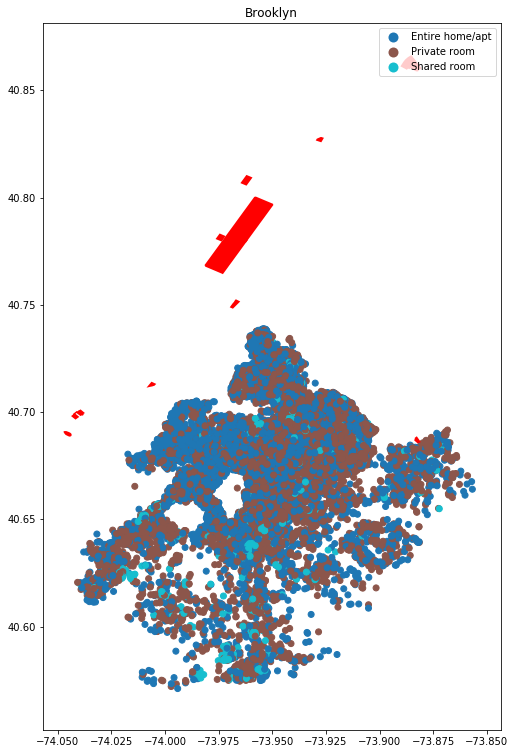

In [47]:
fig,ax = plt.subplots(figsize = (15,13))
brooklyn_gdf.plot(column='room_type', ax=ax, legend=True)
ny_landmarks.plot(ax=ax, color ='red')
plt.title('Brooklyn')

This is the room type plotted on a whole map of New York City to give better reference. 

Text(0.5, 1, 'Brooklyn')

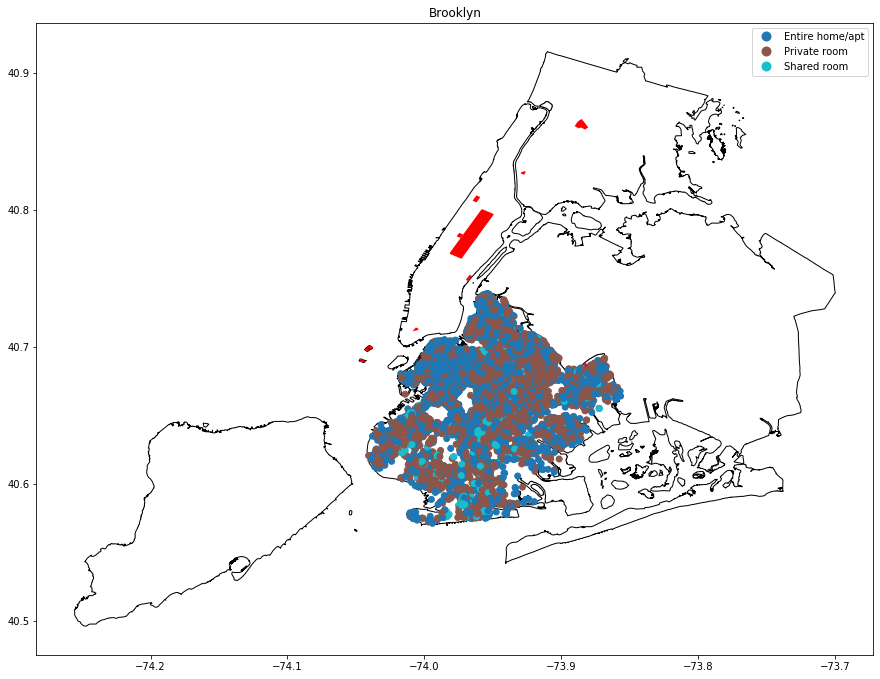

In [48]:
fig,ax = plt.subplots(figsize = (15,13))
boundaries.plot(ax=ax,color="white",edgecolor='black')
brooklyn_gdf.plot(column='room_type', ax=ax, legend=True)
ny_landmarks.plot(ax=ax, color ='red')
plt.title('Brooklyn')

Below is a map of the different rooms avaliable in Manhattan. The red makes are the Landmarks.

Text(0.5, 1, 'Manhattan')

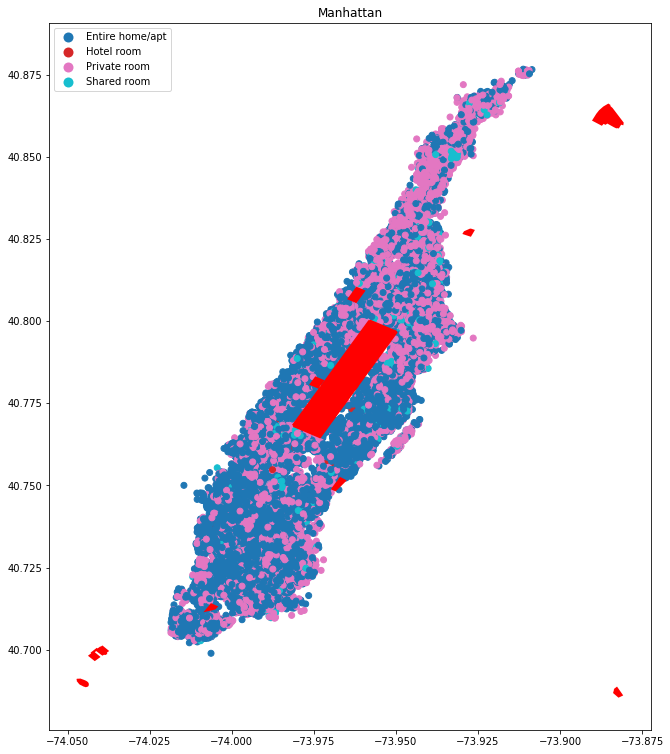

In [49]:
fig,ax = plt.subplots(figsize = (15,13))
manhattan_gdf.plot(column='room_type', ax=ax, legend=True)
ny_landmarks.plot(ax=ax, color ='red')
plt.title('Manhattan')

This is the room type plotted on a whole map of New York City to give better reference.

Text(0.5, 1, 'Manhattan')

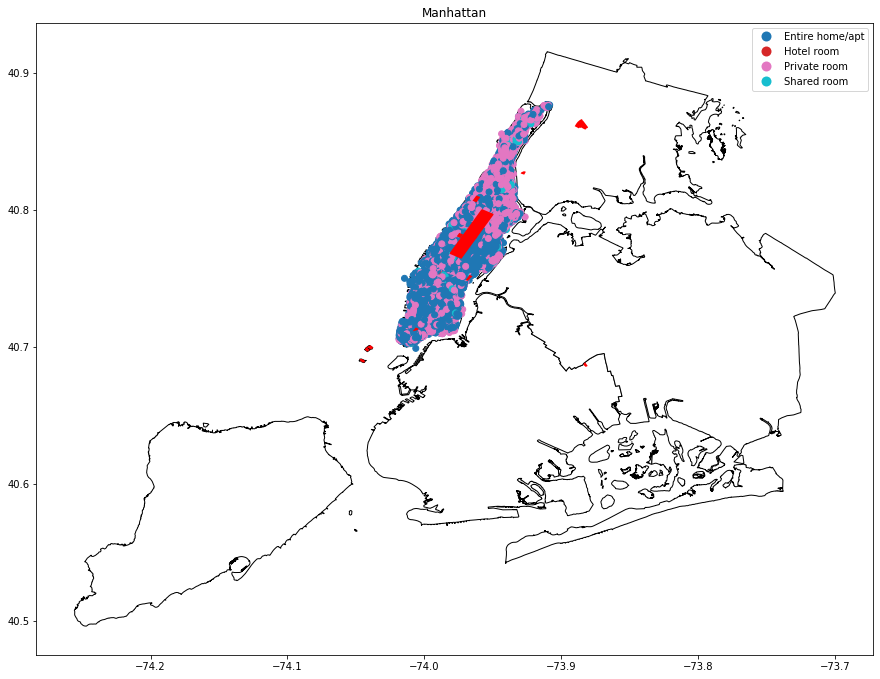

In [51]:
fig,ax = plt.subplots(figsize = (15,13))
boundaries.plot(ax=ax,color="white",edgecolor='black')
manhattan_gdf.plot(column='room_type', ax=ax, legend=True)
ny_landmarks.plot(ax=ax, color ='red')
plt.title('Manhattan')

Below is a colormap plotting the price of each entire homes or apartments below $600 in Manhattan. This cut off is used to make the colors vary more on the map. 

We can see that the prices in the South Western part of Manhattan are generally higher. 

Text(0.5, 1, 'Price of Rooms in Manhattan')

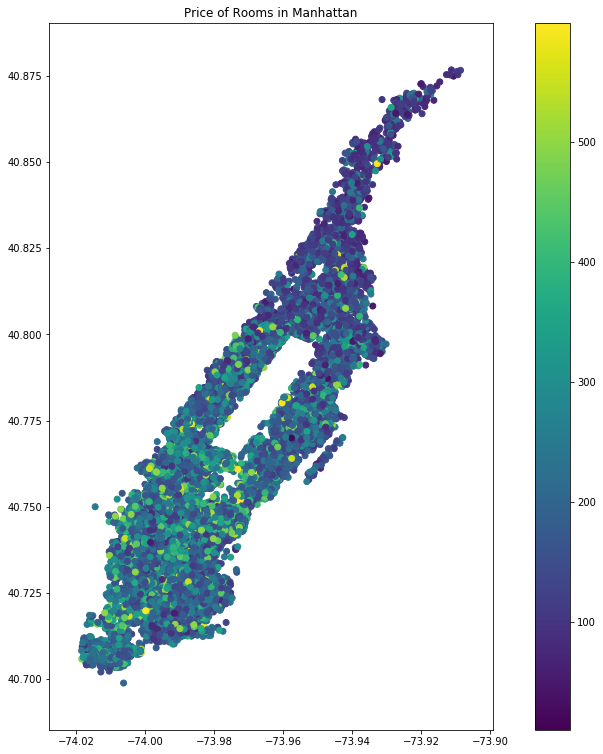

In [52]:
fig,ax = plt.subplots(figsize = (15,13))
manhattan_gdf[(manhattan_gdf['room_type']=='Entire home/apt')&(manhattan_gdf['price']<600)].plot(['price'], ax=ax, legend=True)
plt.title('Price of Rooms in Manhattan')


Below is a colormap plotting the price of each entire homes or apartments below $400 in Brooklyn. This cut off is used to make the colors vary more on the map.

Here we can see that the prices in the northern part of Brooklyn are more expensive. 

Text(0.5, 1, 'Price of Rooms in Brooklyn')

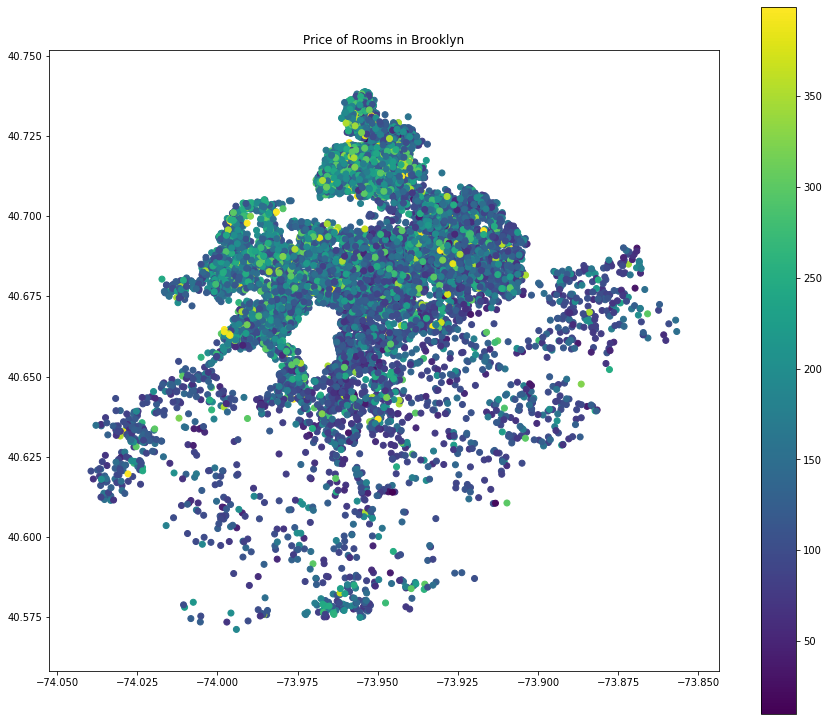

In [53]:
fig,ax = plt.subplots(figsize = (15,13))
brooklyn_gdf[(brooklyn_gdf['room_type']=='Entire home/apt')&(brooklyn_gdf['price']<400)].plot(['price'], ax=ax, legend=True)
plt.title('Price of Rooms in Brooklyn')

Here are the two price maps together. We are able to see that as we closer to the split of Brooklyn and Manhattan, the prices increase. We can also see that there are a varitey of landmarks around where the price increases are. This helps show us where in New York is more expensive.

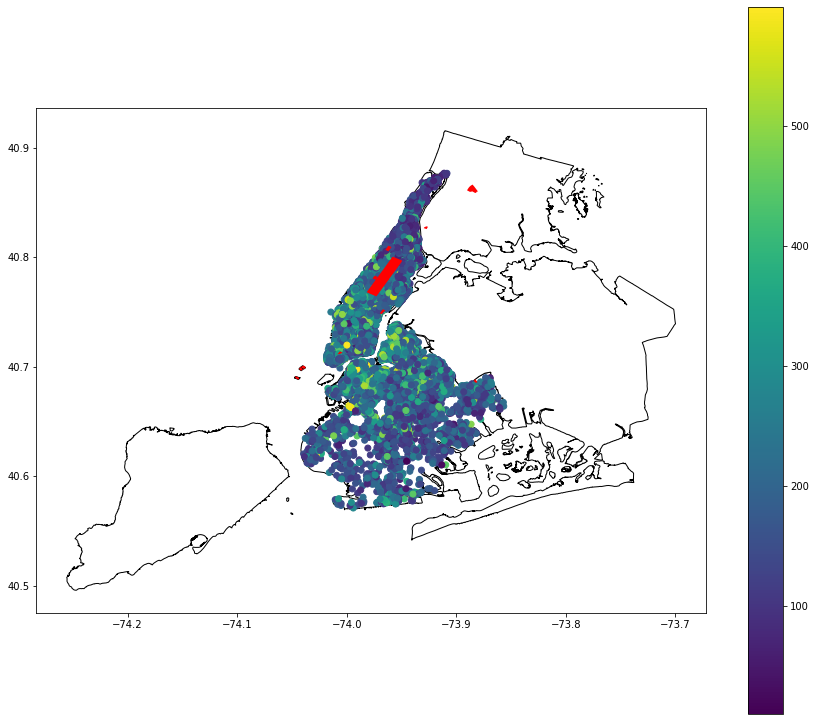

In [54]:
fig,ax = plt.subplots(figsize = (15,13))
boundaries.plot(ax=ax,color="white",edgecolor='black')
brooklyn_gdf[(brooklyn_gdf['room_type']=='Entire home/apt')&(brooklyn_gdf['price']<400)].plot(['price'], ax=ax)
manhattan_gdf[(manhattan_gdf['room_type']=='Entire home/apt')&(manhattan_gdf['price']<600)].plot(['price'], ax=ax, legend=True)
ny_landmarks.plot(ax=ax, color ='red')


Through our analysis we were able to uncover a lot of information out about Airbnb usage in New York City. 

Firstly we were able to pinpoint that across New York, the winter months of November to January were the busiest times of year. With many iconic holidays this makes sense. This doesn’t match our hypothesis of the busiest months being in the summer, however we were also able to see that certain areas of New York are busier in the summer such as Staten Island. Overall, summer seemed to be the second busiest season based on price surging and bookings. 

We were also able to determine that the busiest tourist areas in New York are Manhattan and Brooklyn. This makes sense as many of New York’s iconic and most notable tourist destinations are in these areas. However it was also interesting to see how the prices varied across neighborhoods in these boroughs. We were able to notice that the south eastern part of Manhattan is more expensive than the northern part. Similarly with Brooklyn we can see that the north western part is more expensive, which is where these two boroughs meet. The properties near water on the divide of the two boroughs seem to also have high cost. 

Through this data exploration we are able to see that New York is a very dynamic city with an airbnb for everyone's needs. There is a huge range in price that is considerably more affordable than the traditional hotel. It will be interesting to see how this business will continue to evolve and change. 


# Team contributions

Zack - Background research and final write-ups

Myra - Data compiling and cleaning

Molly - Analysis, graphs, and spatial data analysis

Brian - Analysis and graphs